In [2]:
# Step 2: Define StudentDataset class
class StudentDataset:
    def __init__(self, num_students: int = 10000, seed: int = None, username: str = "user"):
        """
        Generates the full dataset at initialization.
        You should NOT regenerate data in other cells.
        """
        self.num_students = num_students
        self.seed = seed
        self.username = username

        # Dedicated random number generator for reproducibility
        self.rng = np.random.default_rng(self.seed)

        # Generate all columns
        self.genders = self.generate_gender()
        self.majors = self.generate_major()
        self.programs = self.generate_program(self.majors)
        self.gpa = self.generate_gpa(self.majors)

        # Assemble final DataFrame
        self._df = self.assemble_dataframe()

        # Confirmation message
        print(f"Dataset generated successfully for '{self.username}' with {len(self._df)} students.")

    def get_full_dataframe(self) -> pd.DataFrame:
        """Return the same DataFrame object generated at init."""
        return self._df.copy()

    def generate_gender(self):
        # Male 65%, Female 33%, Other 2%
        choices = ["Male", "Female", "Other"]
        probs = [0.65, 0.33, 0.02]
        return list(self.rng.choice(choices, size=self.num_students, p=probs))

    def generate_major(self):
        # B.Tech 70%, MS 20%, PhD 10%
        choices = ["B.Tech", "MS", "PhD"]
        probs = [0.7, 0.2, 0.1]
        return list(self.rng.choice(choices, size=self.num_students, p=probs))

    def generate_program(self, majors):
        # Program distribution depends on major
        programs = []
        for m in majors:
            if m == "B.Tech":
                probs = [0.4, 0.4, 0.1, 0.1]  # CSE, ECE, CHD, CND
            elif m == "MS":
                probs = [0.3, 0.3, 0.2, 0.2]
            else:  # PhD
                probs = [0.25, 0.25, 0.25, 0.25]
            choices = ["CSE", "ECE", "CHD", "CND"]
            programs.append(self.rng.choice(choices, p=probs))
        return programs

    def generate_gpa(self, majors):
        # GPA ~ Normal(mean, std) per major, clipped to [4.0, 10.0]
        gpas = []
        for m in majors:
            if m == "B.Tech":
                mu, sigma = 7.0, 1.0
            elif m == "MS":
                mu, sigma = 8.0, 0.7
            else:  # PhD
                mu, sigma = 8.3, 0.5
            val = self.rng.normal(mu, sigma)
            gpas.append(float(np.clip(val, 4.0, 10.0)))
        return gpas

    def assemble_dataframe(self):
        # Assemble everything into a single pandas DataFrame
        df = pd.DataFrame({
            "gender": self.genders,
            "major": self.majors,
            "program": self.programs,
            "GPA": self.gpa
        })
        df.index.name = "student_id"
        df.attrs['username'] = self.username
        return df

    # Q1.5: Program-Major Balanced Cohort
    def sample_program_major_balanced(self, n: int) -> pd.DataFrame:
        df = self.get_full_dataframe()
        combos = df.groupby(['program', 'major'])
        num_combos = len(combos)
        samples_per_combo = n // num_combos
        remainder = n % num_combos
        sampled_list = []
        too_small_groups = []

        for name, group in combos:
            replace_flag = len(group) < samples_per_combo
            if replace_flag:
                too_small_groups.append(name)
            sampled = group.sample(samples_per_combo, replace=replace_flag,
                                   random_state=self.rng.integers(0, 1e9))
            sampled_list.append(sampled)

        sampled_df = pd.concat(sampled_list)

        if remainder > 0:
            extra_samples = df.sample(remainder, replace=True,
                                      random_state=self.rng.integers(0, 1e9))
            sampled_df = pd.concat([sampled_df, extra_samples])

        sampled_df = sampled_df.reset_index(drop=True)
        self._too_small_groups = too_small_groups
        return sampled_df

    def show_program_major_counts_and_heatmap(self, sampled_df: pd.DataFrame) -> None:
        counts = sampled_df.groupby(['program', 'major']).size().unstack(fill_value=0)
        print("Counts per (Program, Major):\n", counts)

        plt.figure(figsize=(8,5))
        sns.heatmap(counts, annot=True, fmt='d', cmap='YlGnBu')
        plt.title(f"Program-Major Balanced Cohort Counts ({self.username})")
        plt.ylabel("Program")
        plt.xlabel("Major")
        plt.show()

        if hasattr(self, "_too_small_groups") and self._too_small_groups:
            print("\nWarning: Some (Program, Major) groups were smaller than allocated quota.")
            print("Groups that were too small:", self._too_small_groups)
        else:
            print("\nAll groups had enough students for equal allocation.")


In [3]:
username = "riya"   
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)

Dataset generated successfully for 'riya' with 10000 students.


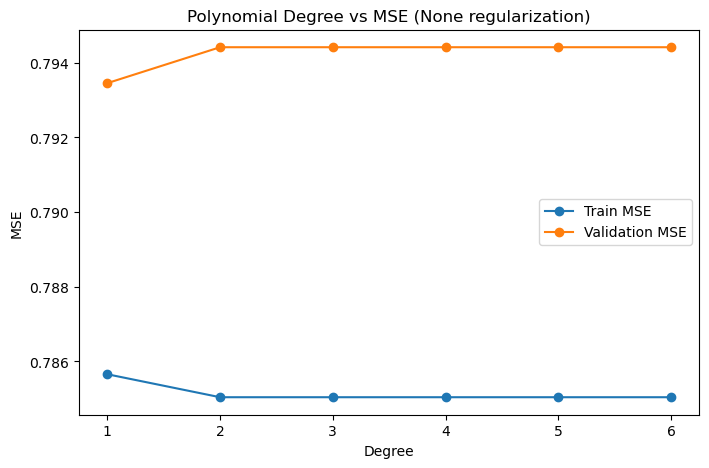

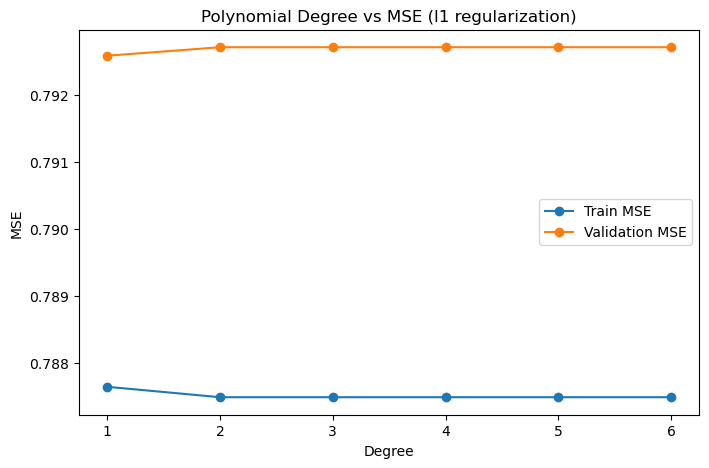

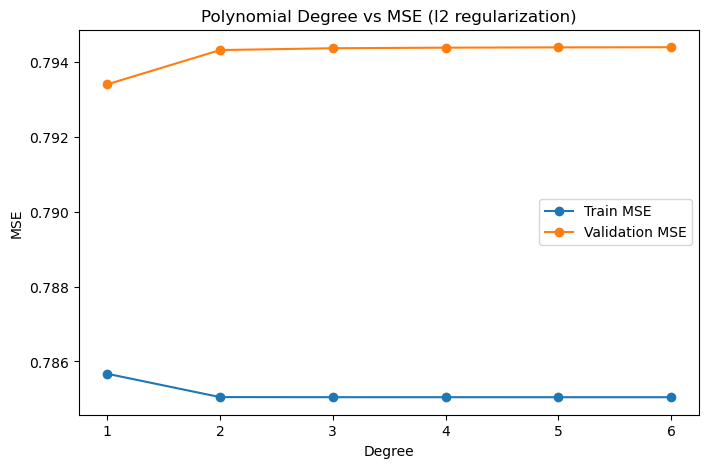

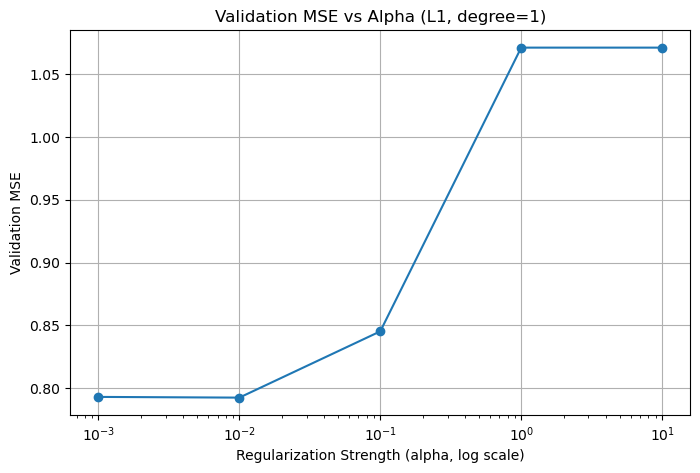

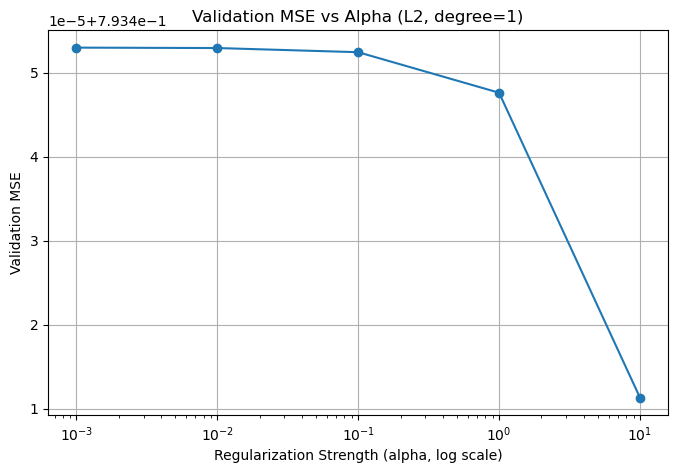

Best Setup:
Regularizer: l1, Degree: 1, Alpha: 0.01
Non-zero coefficients:
             feature      coef
0  cat__major_B.Tech -1.026807
2     cat__major_PhD  0.176405
5   cat__program_CSE -0.006880


In [4]:

# Q3: Linear Regression with Regularization


from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 1️ Get dataset

dataset = StudentDataset(num_students=10000, seed=seed, username="riya")
full_df = dataset.get_full_dataframe()

# Features and target
features = ['major', 'program']  # categorical
target = 'GPA'


# 2️ Train/Val/Test split

train_df, temp_df = train_test_split(full_df, test_size=0.4, random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)

# Separate X and y
X_train = train_df[features]
y_train = train_df[target].values
X_val = val_df[features]
y_val = val_df[target].values
X_test = test_df[features]
y_test = test_df[target].values


# 3️ Preprocessing

categorical_features = ['major', 'program']
numeric_features = []  # no numeric features in X currently

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),
    ], remainder='passthrough'
)

# Fit preprocessor on training data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)


# 4️ Define run_poly_regression function

def run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                        degree=1, regularizer=None, reg_strength=0.0):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    
    if regularizer is None:
        model = LinearRegression()
    elif regularizer.lower() == 'l2':
        model = Ridge(alpha=reg_strength)
    elif regularizer.lower() == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=10000)
    else:
        raise ValueError("Unknown regularizer. Use None, 'l1' or 'l2'.")
    
    model.fit(X_train_poly, y_train)
    
    mse_train = mean_squared_error(y_train, model.predict(X_train_poly))
    mse_val = mean_squared_error(y_val, model.predict(X_val_poly))
    mse_test = mean_squared_error(y_test, model.predict(X_test_poly))
    
    return {
        "train_mse": mse_train,
        "val_mse": mse_val,
        "test_mse": mse_test,
        "coefficients": model.coef_,
        "intercept": model.intercept_,
        "poly_features": poly.get_feature_names_out(preprocessor.get_feature_names_out())
    }


# 5️ Hyperparameter search

degrees = range(1, 7)
alphas = [0.001, 0.01, 0.1, 1, 10]
results = []

for reg in [None, 'l1', 'l2']:
    for d in degrees:
        best_val = float('inf')
        best_alpha = None
        for alpha in (alphas if reg is not None else [0.0]):
            res = run_poly_regression(X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
                                      degree=d, regularizer=reg, reg_strength=alpha)
            if res['val_mse'] < best_val:
                best_val = res['val_mse']
                best_alpha = alpha
                best_res = res
        results.append({
            "regularizer": reg,
            "degree": d,
            "best_alpha": best_alpha,
            "train_mse": best_res['train_mse'],
            "val_mse": best_val,
            "test_mse": best_res['test_mse'],
            "coefficients": best_res['coefficients'],
            "features": best_res['poly_features']
        })


# 6️ Plots: Polynomial Degree vs MSE

for reg in [None, 'l1', 'l2']:
    train_mse = [r['train_mse'] for r in results if r['regularizer']==reg]
    val_mse = [r['val_mse'] for r in results if r['regularizer']==reg]
    plt.figure(figsize=(8,5))
    plt.plot(degrees, train_mse, marker='o', label='Train MSE')
    plt.plot(degrees, val_mse, marker='o', label='Validation MSE')
    plt.title(f"Polynomial Degree vs MSE ({reg} regularization)")
    plt.xlabel("Degree")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()


# 7️ Plot: Regularization Strength vs Validation MSE for best degree

for reg in ['l1', 'l2']:
    best_degree = min([r for r in results if r['regularizer']==reg], key=lambda x: x['val_mse'])['degree']
    val_mse_alpha = []
    for alpha in alphas:
        res = run_poly_regression(X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
                                  degree=best_degree, regularizer=reg, reg_strength=alpha)
        val_mse_alpha.append(res['val_mse'])
    plt.figure(figsize=(8,5))
    plt.semilogx(alphas, val_mse_alpha, marker='o')
    plt.title(f"Validation MSE vs Alpha ({reg.upper()}, degree={best_degree})")
    plt.xlabel("Regularization Strength (alpha, log scale)")
    plt.ylabel("Validation MSE")
    plt.grid(True)
    plt.show()


# 8️ Best setup coefficients

best_setup = min(results, key=lambda x: x['test_mse'])
print("Best Setup:")
print(f"Regularizer: {best_setup['regularizer']}, Degree: {best_setup['degree']}, Alpha: {best_setup['best_alpha']}")
df_coef = pd.DataFrame({
    "feature": best_setup['features'],
    "coef": best_setup['coefficients']
})
print("Non-zero coefficients:")
print(df_coef[df_coef['coef']!=0])
